# Упражнения
В этом упражнении рассматривается прогноз SARIMA, аналогичный тому, который был сделан для набора данных $CO_2$.



In [1]:
!pip install pmdarima

In [45]:
# 
import pandas as pd
import numpy as np
%matplotlib inline

# импорт SARIMAX 
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # для определения (p,q) 
from statsmodels.tsa.seasonal import seasonal_decompose      # для ETS графиков
from pmdarima import auto_arima                              # для поиска ARIMA моделей

# метрики
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# для игнорирования предупреждений (опционально)
# import warnings
# warnings.filterwarnings("ignore")

# Загрузка датасета ( индексом утанавливается колонка 'Date')
df = pd.read_csv('HospitalityEmployees.csv',index_col='Date',parse_dates=True)
df.index.freq = 'MS' # дискретность записей - один месяц
print(len(df)) # определение количество записей в датасете
print(df.head())

348
            Employees
Date                 
1990-01-01     1064.5
1990-02-01     1074.5
1990-03-01     1090.0
1990-04-01     1097.4
1990-05-01     1108.7


В датасете <tt>df</tt>  348 записей и 1 колонка. Данные представляют собой численность сотрудников в тысячах человек в среднем за месяц с января 1990 года по декабрь 2018 года.

### 1. Построим график временного ряда для общего анализа данных


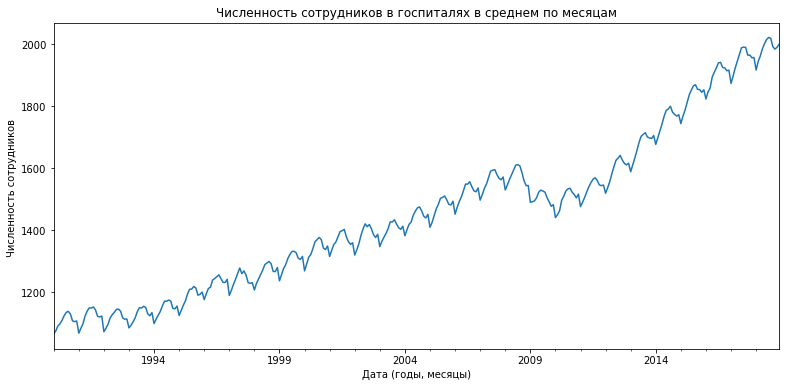

In [46]:
ax = df['Employees'].plot(figsize=(13,6))
ax.set_title( 'Численность сотрудников в госпиталях в среднем по месяцам')
ax.set_xlabel('Дата (годы, месяцы)')
ax.set_ylabel('Численность сотрудников ')
ax.autoscale(axis = 'x', tight = True)



In [ ]:
# На графике наблюдается определенная тенденция и периодичность изменения данных. Присутствует
# локальный 'выброс' около 2009 года. Для дальнейшего анализа проведем декомпозицию данных

### 2. Выполнение  ETS декомпозиции
Используя аддитивную модель ('additive').


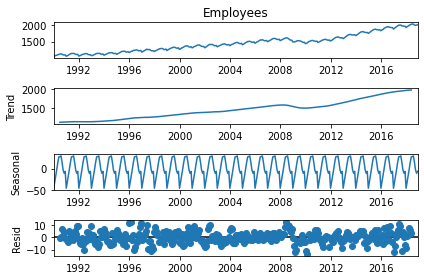

In [19]:
r = seasonal_decompose(df['Employees'], model = 'additive')
r.plot();

### 3. Использование  <tt>pmdarima.auto_arima</tt> для  получения набора параметров


In [21]:
# период сезонности 1 год
auto_arima(df['Employees'], seasonal = True, m = 12).summary()


C:\Users\79165\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,1,2)(2,0,2)[12]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\79165\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\79165\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 597, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\79165\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 518, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\79165\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 508, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,
  File "C:\Users\79165\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 690, in fit
    mlefit = super(MLEModel, self).fit(start_para

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  348
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1098.252
Date:                              Sat, 05 Mar 2022   AIC                           2208.504
Time:                                      11:34:04   BIC                           2231.600
Sample:                                           0   HQIC                          2217.700
                                              - 348                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9248      0.045     20.613      0.000       0.837       1.013
ma.L1         -0.9443      0.070    -13.542      0.000      -1.081      -0.808
ma.L2          0.1286      0.060      2.146      0.032       0.011       0.246
ar.S.L12       0.9972      0.001    704.926      0.000       0.994       1.000
ma.S.L12      -0.7491      0.043    -17.348      0.000      -0.834      -0.665
sigma2        29.3011      1.718     17.054      0.000      25.934      32.669
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                67.47
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.11
Prob(H) (two-sided):                  0.40   Kurtosis:                         5.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Полученный результат ARIMA (1,1,2) с сезонностью (1,0,[1],12).

### 4. Разделим данные на обучающий train и тестовый test наборы
Установим один (последний) год (12 записей) для тестирования. 

In [24]:
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:]

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

### 5. Обучение модели  SARIMA(1,1,2)(1,0,[1],12) на обучающей наборе train['Employees']


In [26]:
model = SARIMAX(train['Employees'],order = (1,1,2), seasonal_order = (1,0,1,12))
results = model.fit()
results.summary()

C:\Users\79165\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\79165\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\79165\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Employees   No. Observations:                  336
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1058.058
Date:                              Sat, 05 Mar 2022   AIC                           2128.116
Time:                                      11:52:00   BIC                           2151.001
Sample:                                  01-01-1990   HQIC                          2137.240
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9240      0.044     21.170      0.000       0.838       1.010
ma.L1         -0.9584      0.070    -13.778      0.000      -1.095      -0.822
ma.L2          0.1500      0.060      2.491      0.013       0.032       0.268
ar.S.L12       0.9973      0.001    731.029      0.000       0.995       1.000
ma.S.L12      -0.7519      0.044    -17.168      0.000      -0.838      -0.666
sigma2        28.7641      1.684     17.083      0.000      25.464      32.064
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                73.31
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.17
Prob(H) (two-sided):                  0.63   Kurtosis:                         5.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 6. Вычисление прогнозных значений

In [27]:
start = len(train)
end = len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename(' Predictions SARIMAX(1, 1, 2)x(1, 0, [1], 12)')

### 7. Отобразим графики прогнозируемых и известных значений


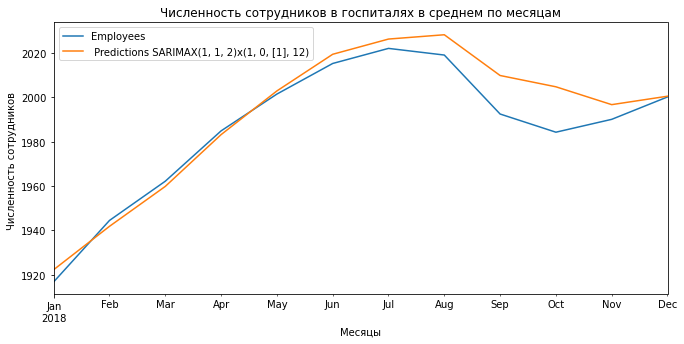

In [30]:
ax = test['Employees'].plot(legend = True, figsize = (11,5)) # График известных тестовых значений
predictions.plot(legend = True) # График прогнозируемых ( в соответствии с моделью) значений
ax.set_title( 'Численность сотрудников в госпиталях в среднем по месяцам')
ax.set_xlabel('Месяцы')
ax.set_ylabel('Численность сотрудников ')
ax.autoscale(axis = 'x', tight = True)

In [ ]:
# График показываем достаточно 'качественный' прогноз на тестовой выборке

### 8. Оцениваем качество модели с помощью MSE и RMSE


In [33]:
# оценка модели методами MSE и RMSE
mse_value = mean_squared_error(test['Employees'], predictions)
rmse_value = rmse(test['Employees'], predictions)

print(f'SARIMAX(1, 1, 2)x(1, 0, [1], 12) MSE Error: {mse_value:11.10}')
print(f'SARIMAX(1, 1, 2)x(1, 0, [1], 12) RMSE Error: {rmse_value:11.10}')

SARIMAX(1, 1, 2)x(1, 0, [1], 12) MSE Error: 77.63067734
SARIMAX(1, 1, 2)x(1, 0, [1], 12) RMSE Error: 8.810827279


In [ ]:
# с учетом величины RMSE ( ошибки модели) будет считать качество модели удовлетворительным

### 9. Тренировка модели на всем датасете и прогнозирование на год вперед

In [34]:
model_full = SARIMAX(df['Employees'],order = (1,1,2), seasonal_order = (1,0,1,12))
results_full = model.fit()
results_full.summary()

C:\Users\79165\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\79165\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\79165\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Employees   No. Observations:                  336
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1058.058
Date:                              Sat, 05 Mar 2022   AIC                           2128.116
Time:                                      12:17:26   BIC                           2151.001
Sample:                                  01-01-1990   HQIC                          2137.240
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9240      0.044     21.170      0.000       0.838       1.010
ma.L1         -0.9584      0.070    -13.778      0.000      -1.095      -0.822
ma.L2          0.1500      0.060      2.491      0.013       0.032       0.268
ar.S.L12       0.9973      0.001    731.029      0.000       0.995       1.000
ma.S.L12      -0.7519      0.044    -17.168      0.000      -0.838      -0.666
sigma2        28.7641      1.684     17.083      0.000      25.464      32.064
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                73.31
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.17
Prob(H) (two-sided):                  0.63   Kurtosis:                         5.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
#строим прогноз на год вперед
forecast = results_full.predict(start=len(df)-1, end=len(df)+11,typ='levels').rename('SARIMAX(1, 1, 2)x(1, 0, [1], 12)Forecast')


### 10. Постройте график предсказаний и график исходных данных


Text(0, 0.5, 'Численность сотрудников')

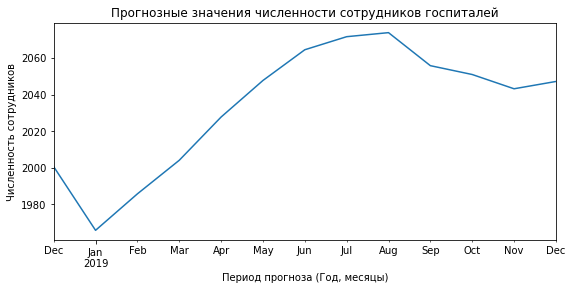

In [42]:
ax = forecast.plot(figsize = (9,4))
ax.set_title('Прогнозные значения численности сотрудников госпиталей')
ax.set_xlabel('Период прогноза (Год, месяцы)')
ax.set_ylabel('Численность сотрудников')

In [ ]:
# Прогнозная модель 'адекватно' отображает периодичность исходных данных на интервале год
# для визуализации 'соответствия стат характеристик  прогнозной модели исходному набору данных
# построим общий график ( исходные данные плюс период прогноза)

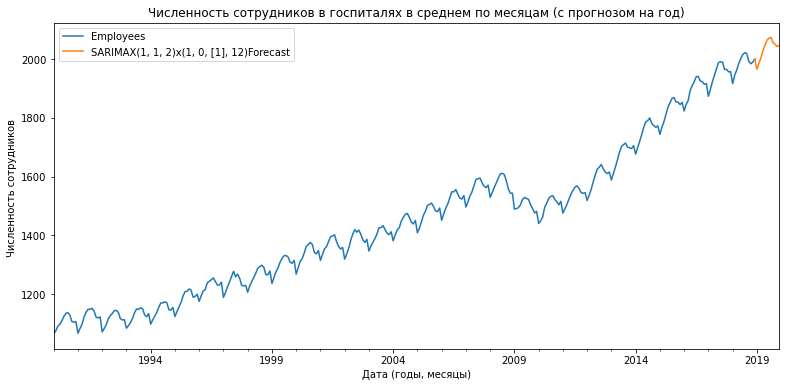

In [44]:
#Строим совместный график существующей выборки и прогноза на год вперед ( для визуальной оценки
# качества построенной модели )
ax = df['Employees'].plot(figsize=(13,6), legend = True)
forecast.plot(legend = True)
ax.set_title( 'Численность сотрудников в госпиталях в среднем по месяцам (с прогнозом на год)')
ax.set_xlabel('Дата (годы, месяцы)')
ax.set_ylabel('Численность сотрудников ')
ax.autoscale(axis = 'x', tight = True)

In [ ]:
# Из полученного графика возможно сделать заключение о том что полученная модель в достаточной
# мере отражает основные статистические характеристики набора данных ( тренд, сезонность)